# Getting Started With Python For Data Science

This is a quick tutorial about doing data science with Python. The code is quite similar to Kaggle's tutorial, we also use the [Biological Response](https://www.kaggle.com/c/bioresponse) dataset. However, we will go a little further & see how to optimize our model with [scikit-learn](http://scikit-learn.org/stable/install.html) armed weapons ;) 

## The dataset

Our task is to *predict a biological response of molecules from their chemical properties*. So, here we have the actual biological response (1) the molecule was seen to elicit this response, or not (0); together with 1776 molecular descriptors e.g. size, shape, elemental constitution, ect.

In [1]:
import numpy as np
from numpy import genfromtxt, savetxt

dataset = genfromtxt(open('data/train.csv','r'), delimiter=',', dtype='f8')[1:]
target  = np.asarray([x[0] for x in dataset])
train   = np.asarray([x[1:] for x in dataset])

test = np.asarray(genfromtxt(open('data/test.csv', 'r'), delimiter=',', dtype='f8')[1:])

Let's take a quick glance at the data, you can change the number of features to display and the offset to the first features by adjusting _num_features_ and _offset_. The datapoints above _x=0_ corresponse to positive example and vice versa. 

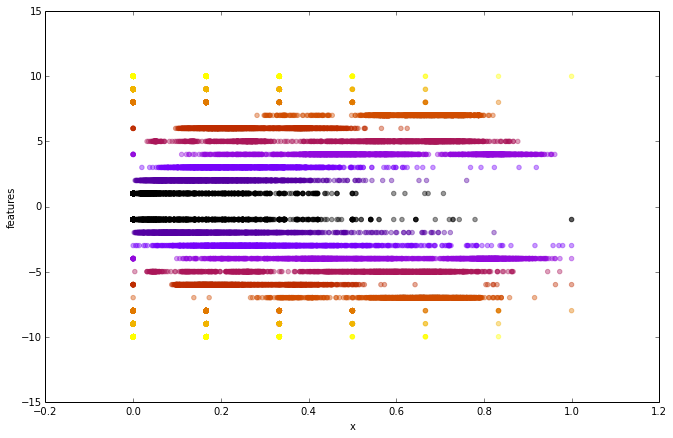

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

num_features = 10
offset       = 100

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, num_features)]

def plot_data(alpha=0.4, s=20):
    fig = plt.figure(figsize=(11,7))

    for i in xrange(num_features):
        plt.scatter(train[:,i + offset], (target*2-1)*(i+1), s=s, alpha=alpha,color=colors[i])
        
    plt.ylabel('features')
    plt.xlabel('x')

plot_data()

The evaluation metric for this dataset is [log-loss](https://www.kaggle.com/wiki/LogarithmicLoss). In short, instead of ouputing 0 and 1, we will predict how likely we get 0 or 1 given a set of parameters. Then, we compare this value with the actual probability using the log-loss.

$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$
$$log loss = -\frac{1}{N}\sum_{i=1}^N {(y_i\log(p_i) + (1 - y_i)\log(1 - p_i))}$$

In [18]:
import scipy as sp
from sklearn.metrics import make_scorer

def llfun(pred, act):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act * sp.log(pred) + sp.subtract(1,act) * sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

scorer = make_scorer(llfun, greater_is_better=False)

##Gradient Boosting Classifier

Let's say we need to predict a binary classifier (0 and 1) from a bunch of numbers, the Gradient Boosting Regression Trees might be a good candidate to solve our problem. The idea behind GBRT is to continuously optimize the decision trees to come up with a final good predict tree. In order to come up with a good model, we have to consider several important hyperparameters. 

Here is the recipe to tune the hyperparameters for GBRT (by [Peter Prettenhofer](peter.prettenhofer@gmail.com)):

* Pick *n_estimators* as large as (computationally) possible (e.g. 3000)
* Tune *max_depth, learning_rate, min_samples_leaf, and max_features* via grid search
* Increase *n_estimators* even more and tune learning_rate again holding the other parameters fixed

Keep in mind:
* *max_depth* - controls the degree of features interactions (variance++)
* *min_samples_leaf* - to have a sufficient number of samples per leaf (bias++)
* *max_features* - Subsampling the features before finding the best split node

Enough talking, let's start tuning our model :)

In [22]:
from sklearn.cross_validation import train_test_split
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import f_classif

# train = SelectKBest(f_classif, k=800).fit_transform(train, target)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.1, random_state=1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV

param_grid = {  
                'learning_rate': [0.1, 0.01],
                'max_depth': [5, 8, 16],
                'min_samples_leaf': [3, 5, 8],
#                 'max_features': [1.0, 0.1],
}

est = GradientBoostingClassifier(n_estimators=3000)
gs_cv = GridSearchCV(est, param_grid, scoring=scorer, n_jobs=4).fit(X_train, y_train)

print 'Best hyperparameters: %r' % (gs_cv.best_params_)

Best hyperparameters: {'max_features': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 3}

A quick test \:D/

In [11]:
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)

llfun([x[1] for x in est.predict_proba(X_test)], y_test)

0.79840142095914746

### Deviance plotting

This plot is extremely useful when we have to deal with overfitting. It visualizes the train/test errors w.r.t the complexity of our model (_n_estimators_). Base on this information, we can decide and tune our hyperparameters to achieve the best result

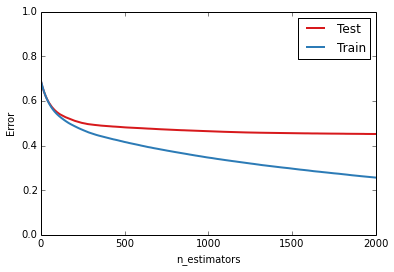

In [32]:
def deviance_plot(est, X_train, y_train, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 1)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    train_dev  = np.empty(n_estimators)
    test_dev  = np.empty(n_estimators)
    
    for i, pred in enumerate(est.staged_predict_proba(X_train)):
        train_dev[i] = llfun([x[1] for x in pred], y_train)
        
    for i, pred in enumerate(est.staged_predict_proba(X_test)):
        test_dev[i] = llfun([x[1] for x in pred], y_test)
        
    if ax is None:
        fig = plt.figure(figsize=(11,7))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, train_dev, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_train, y_train, X_test, y_test)
ax.legend(loc='upper right')

##Let's submit to Kaggle
Don't forget to retrain your classifier with the full given dataset, this might be a great improvement in case we lack of data :) 

In [204]:
est.fit(train, target)
predicted_blobs = [[index+1, x[1]] for index, x in enumerate(est.predict_proba(test))]

savetxt('data/submission.csv', predicted_blobs, delimiter=',', fmt='%d,%f', header='MoleculeId,PredictedProbability', comments='')

Congrats! Now your mission is to win the 1st in Kaggle's leaderboard!